<a href="https://colab.research.google.com/github/cmfritz/capstone/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


In [4]:
df = pd.read_pickle('data/master_data.pkl')
df

,patent_id,text
0,10524402,1. A method comprising: capturing an image of ...
1,10524403,1. A method for determining a weight of a payl...
2,10524404,"1. A break-away assembly, comprising: a swivel..."
3,10524405,"1. An agricultural implement system, comprisin..."
4,10524406,1. A hitch comprising: a tractor; a towed or s...
...,...,...
3001030,10395907,"1. A generator of an ion beam, comprising: an ..."
3001031,10395908,1. A system for converting product ion mass sp...
3001032,10395909,1. A mass spectrometer for performing an MS n ...
3001033,10395910,1. An accelerator mass spectrometry device for...


In [6]:
# Delete this after finalizing models, truncating dataset just to help with runtimes
df = df.iloc[:int(len(df.patent_id)/3)]
df

,patent_id,text
0,10524402,1. A method comprising: capturing an image of ...
1,10524403,1. A method for determining a weight of a payl...
2,10524404,"1. A break-away assembly, comprising: a swivel..."
3,10524405,"1. An agricultural implement system, comprisin..."
4,10524406,1. A hitch comprising: a tractor; a towed or s...
...,...,...
1000340,8571610,1. An electronic communication control system ...
1000341,8564655,1. A three-dimensional measurement method for ...
1000342,8564656,1. A method for identifying surface characteri...
1000343,8571611,1. A headset comprising: a first ear piece hav...


In [7]:
df_pats_w_sectors = pd.read_pickle('data/pats_w_sectors.pkl')
df_pats_w_sectors

,patent_id,sector_title,field_title
0,10001059,Mechanical engineering,Mechanical elements
1,10053304,Mechanical engineering,Mechanical elements
2,10085485,Mechanical engineering,Mechanical elements
3,10138340,Mechanical engineering,Mechanical elements
4,10189524,Mechanical engineering,Mechanical elements
...,...,...,...
9999995,10818791,Chemistry,Micro-structural and nano-technology
9999996,10818792,Chemistry,Micro-structural and nano-technology
9999997,10818805,Chemistry,Micro-structural and nano-technology
9999998,10818835,Chemistry,Micro-structural and nano-technology


In [8]:
len(set(df_pats_w_sectors.patent_id))

6836110

In [9]:
counts = df_pats_w_sectors.patent_id.value_counts()
counts

9639998    8
9870654    8
3992294    8
9773215    8
4055591    8
          ..
6531934    1
7987125    1
5615819    1
5621700    1
6928784    1
Name: patent_id, Length: 6836110, dtype: int64

In [10]:
counts = counts.to_frame()

In [11]:
counts = counts.reset_index()

In [12]:
groups = df_pats_w_sectors.groupby(by='patent_id').count()
groups[groups.sector_title > 1]

,sector_title,field_title
patent_id,,
10000001,2,2
10000002,3,3
10000006,2,2
10000008,2,2
10000010,2,2
...,...,...
9999993,2,2
9999994,4,4
9999996,2,2


In [13]:
df_pats_w_sectors = df_pats_w_sectors.drop(['field_title'], axis=1)
df_pats_w_sectors

,patent_id,sector_title
0,10001059,Mechanical engineering
1,10053304,Mechanical engineering
2,10085485,Mechanical engineering
3,10138340,Mechanical engineering
4,10189524,Mechanical engineering
...,...,...
9999995,10818791,Chemistry
9999996,10818792,Chemistry
9999997,10818805,Chemistry
9999998,10818835,Chemistry


In [14]:
df_pats_w_sectors = df_pats_w_sectors.drop_duplicates()
df_pats_w_sectors

,patent_id,sector_title
0,10001059,Mechanical engineering
1,10053304,Mechanical engineering
2,10085485,Mechanical engineering
3,10138340,Mechanical engineering
4,10189524,Mechanical engineering
...,...,...
9999994,10818777,Chemistry
9999995,10818791,Chemistry
9999996,10818792,Chemistry
9999997,10818805,Chemistry


In [15]:
df_pats_w_sectors.value_counts()

patent_id  sector_title          
9999999    Mechanical engineering    1
5379517    Mechanical engineering    1
5379506    Chemistry                 1
           Instruments               1
5379507    Chemistry                 1
                                    ..
7728176    Chemistry                 1
7728177    Chemistry                 1
7728178    Chemistry                 1
7728179    Chemistry                 1
10000000   Instruments               1
Length: 8272355, dtype: int64

In [16]:
groups2 = df_pats_w_sectors.groupby(by='patent_id').count()
singles = groups2[groups2.sector_title == 1]

In [17]:
len(singles)

5534114

In [18]:
singles = singles.reset_index()
ok_pats = df_pats_w_sectors.merge(singles, on='patent_id')
ok_pats

,patent_id,sector_title_x,sector_title_y
0,10001059,Mechanical engineering,1
1,10189524,Mechanical engineering,1
2,10309306,Mechanical engineering,1
3,10427924,Mechanical engineering,1
4,10428949,Mechanical engineering,1
...,...,...,...
5534109,10800649,Chemistry,1
5534110,10800650,Chemistry,1
5534111,10807862,Chemistry,1
5534112,10807863,Chemistry,1


In [19]:
ok_pats = ok_pats.drop(['sector_title_y'], axis=1)
ok_pats = ok_pats.rename(columns={'sector_title_x':'sector'})
ok_pats

,patent_id,sector
0,10001059,Mechanical engineering
1,10189524,Mechanical engineering
2,10309306,Mechanical engineering
3,10427924,Mechanical engineering
4,10428949,Mechanical engineering
...,...,...
5534109,10800649,Chemistry
5534110,10800650,Chemistry
5534111,10807862,Chemistry
5534112,10807863,Chemistry


In [20]:
ok_pats.patent_id = ok_pats.patent_id.astype('int64')
ok_pats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5534114 entries, 0 to 5534113
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   patent_id  int64 
 1   sector     object
dtypes: int64(1), object(1)
memory usage: 126.7+ MB


In [21]:
# inner join with claims text
df_master = ok_pats.merge(df, how='inner', on='patent_id')
df_master

,patent_id,sector,text
0,10549804,Mechanical engineering,"1. A vehicle, comprising: a frame assembly hav..."
1,8047701,Mechanical engineering,"1. A batch mixer, comprising: a mixer main bod..."
2,10831125,Mechanical engineering,"1. A developer carrying member, comprising: an..."
3,10873657,Mechanical engineering,1. A phone support assembly comprising: a plat...
4,7861373,Mechanical engineering,"1. A lanyard handle, comprising in combination..."
...,...,...,...
745088,10800649,Chemistry,1. A microelectromechanical systems (MEMS) dev...
745089,10800650,Chemistry,1. A semiconductor device comprising: a cavity...
745090,10807862,Chemistry,"1. A semiconductor device, comprising: a semic..."
745091,10807863,Chemistry,1. A method for manufacturing micromechanical ...


In [22]:
set(df_master.sector)

{'Chemistry',
 'Electrical engineering',
 'Instruments',
 'Mechanical engineering',
 'Other fields'}

In [23]:
df_master = df_master[df_master.sector!='Other fields']
df_master

,patent_id,sector,text
0,10549804,Mechanical engineering,"1. A vehicle, comprising: a frame assembly hav..."
1,8047701,Mechanical engineering,"1. A batch mixer, comprising: a mixer main bod..."
2,10831125,Mechanical engineering,"1. A developer carrying member, comprising: an..."
3,10873657,Mechanical engineering,1. A phone support assembly comprising: a plat...
4,7861373,Mechanical engineering,"1. A lanyard handle, comprising in combination..."
...,...,...,...
745088,10800649,Chemistry,1. A microelectromechanical systems (MEMS) dev...
745089,10800650,Chemistry,1. A semiconductor device comprising: a cavity...
745090,10807862,Chemistry,"1. A semiconductor device, comprising: a semic..."
745091,10807863,Chemistry,1. A method for manufacturing micromechanical ...


In [24]:
df_master.text = df_master.text.str.replace('1. ', '')
df_master

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,patent_id,sector,text
0,10549804,Mechanical engineering,"A vehicle, comprising: a frame assembly having..."
1,8047701,Mechanical engineering,"A batch mixer, comprising: a mixer main body; ..."
2,10831125,Mechanical engineering,"A developer carrying member, comprising: an el..."
3,10873657,Mechanical engineering,A phone support assembly comprising: a plate; ...
4,7861373,Mechanical engineering,"A lanyard handle, comprising in combination: a..."
...,...,...,...
745088,10800649,Chemistry,A microelectromechanical systems (MEMS) device...
745089,10800650,Chemistry,A semiconductor device comprising: a cavity en...
745090,10807862,Chemistry,"A semiconductor device, comprising: a semicond..."
745091,10807863,Chemistry,A method for manufacturing micromechanical str...


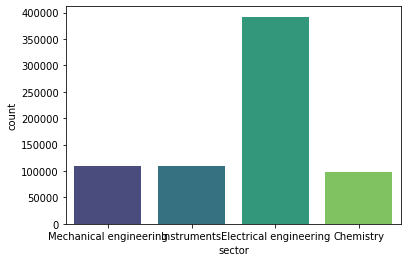

In [25]:
# Look at the counts for each category
ax = sns.countplot(x='sector', data=df_master, palette='viridis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


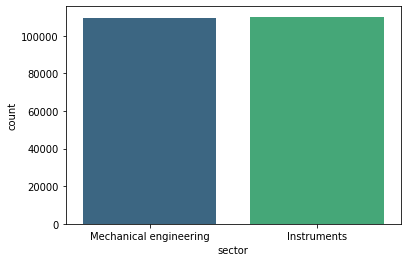

In [36]:
# drop large sectors
df = df_master[df_master.sector != 'Electrical engineering']
df = df[df_master.sector != 'Chemistry']
ax = sns.countplot(x='sector', data=df, palette='viridis')

In [37]:
acceptable = re.compile('[a-zA-Z ]') # regex expression to keep letters and handles

# make a list of the text that fits with regex above
cleanedtext = []
for text in df.text:
    p = ''.join(acceptable.findall(text)).lower()
    cleanedtext.append(p)
df['cleaned_text'] = cleanedtext
df

,patent_id,sector,text,cleaned_text
0,10549804,Mechanical engineering,"A vehicle, comprising: a frame assembly having...",a vehicle comprising a frame assembly having a...
1,8047701,Mechanical engineering,"A batch mixer, comprising: a mixer main body; ...",a batch mixer comprising a mixer main body a h...
2,10831125,Mechanical engineering,"A developer carrying member, comprising: an el...",a developer carrying member comprising an elec...
3,10873657,Mechanical engineering,A phone support assembly comprising: a plate; ...,a phone support assembly comprising a plate a ...
4,7861373,Mechanical engineering,"A lanyard handle, comprising in combination: a...",a lanyard handle comprising in combination a b...
...,...,...,...,...
744657,10814515,Mechanical engineering,A core processing apparatus configured for cut...,a core processing apparatus configured for cut...
744658,10814516,Mechanical engineering,A system comprising: a processor; and a memory...,a system comprising a processor and a memory c...
744659,10814518,Mechanical engineering,"A chainsaw, comprising: a guide bar; a saw cha...",a chainsaw comprising a guide bar a saw chain ...
744660,10814520,Mechanical engineering,A system for reducing the formation of planer ...,a system for reducing the formation of planer ...


In [38]:
y = df['sector']
X = df['cleaned_text']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [47]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [42]:
def tokenize(text):
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [49]:
vec = CountVectorizer(ngram_range=(1,3),
                      tokenizer=tokenize, 
                      stop_words='english')

In [50]:
X_train_transformed = vec.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed.toarray(), columns = vec.get_feature_names())

X_test_transformed = vec.transform(X_test)
X_test = pd.DataFrame(X_test_transformed.toarray(), columns = vec.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [51]:
def train_and_predict(model, X_train, y_train):
    '''
    Given a model and train and test data, function fits the model and returns predicted values.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    Xy: updated Xy object with X & y prediction data (y_hat_train and y_hat_test)
    
    '''
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_hat_train = model.predict(X_train)
    
    # Make predictions for test data
    y_hat_test = model.predict(X_test)
    
    return y_hat_train, y_hat_test

In [52]:
def model_scores(model, 
                 X_train, X_test, 
                 y_train, y_test, 
                 y_hat_train, y_hat_test):
    '''
    Takes model and test train data objects and generates scores and confusion matrix.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    printed text and visualizations
    '''
    # Caclulate accuracy for test data
    train_accuracy = accuracy_score(y_train, y_hat_train)
    print('Training Accuracy: {:.4}%'.format(train_accuracy * 100))

    # Caclulate accuracy for test data
    test_accuracy = accuracy_score(y_test, y_hat_test)
    print('Test Accuracy: {:.4}%\n'.format(test_accuracy * 100))

    # Caclulate recall for train data
    train_f1 = recall_score(y_train, y_hat_train, pos_label='Instruments')
    print('Training Recall Score: {:.4}%'.format(train_f1 * 100))

    # Calculate recall for test data
    test_f1 = recall_score(y_test, y_hat_test, pos_label='Instruments')
    print('Test Recall Score: {:.4}%\n'.format(test_f1 * 100))    

    # Caclulate F1 for train data
    train_f1 = f1_score(y_train, y_hat_train, pos_label='Instruments')
    print('Training F1 Score: {:.4}%'.format(train_f1 * 100))

    # Calculate F1 for test data
    test_f1 = f1_score(y_test, y_hat_test, pos_label='Instruments')
    print('Test F1 Score: {:.4}%'.format(test_f1 * 100))

    # Plot confusion matrix
    print('\nConfusion Matrix for test data')
    plot_confusion_matrix(model, X=X_test, y_true=y_test, values_format = 'd')
    plt.show()

In [53]:
# Initiate the model
logreg = LogisticRegression(random_state=42, n_jobs=1)

logreg.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = logreg.predict(X_train)

# Make predictions for test data
y_hat_test = logreg.predict(X_test)

# Evaluate model
model_scores(logreg, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

ValueError: ignored

Training Accuracy: 99.98%
Test Accuracy: 80.64%

Training Recall Score: 100.0%
Test Recall Score: 80.15%

Training F1 Score: 99.98%
Test F1 Score: 79.71%

Confusion Matrix for test data


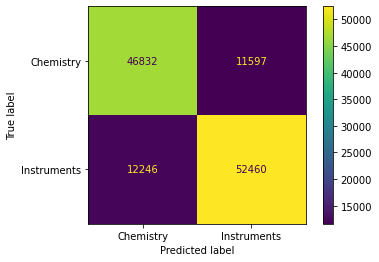

In [40]:
# Initiate the model
dt = DecisionTreeClassifier(random_state=42)  
dt.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = dt.predict(X_train)

# Make predictions for test data
y_hat_test = dt.predict(X_test)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

In [41]:
def run_grid_search(params, model, X_train, y_train):
    '''
    Takes in parameters, model, and test train data, runs grid search, and 
    returns updated model and test train data.
    
    Parameters: 
    params: dict with parameters for grid search
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    gs: object containing updated model
    Xy: object with test train data
    '''
    gs = GridSearchCV(model, params, scoring='f1_macro', cv=None, n_jobs=1)
    gs = gs.fit(X_train, y_train)
    best_parameters = gs.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    # Make predictions for test data
    y_hat_train = gs.predict(X_train)
    
    # Make predictions for test data
    y_hat_test = gs.predict(X_test)
    
    return gs, y_hat_train, y_hat_test

In [42]:
# define parameters to search
params_dt = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(2,10),
    'min_samples_split':range(3,10),
    'min_samples_leaf':range(3,5)
    }

# run grid search
dt, y_hat_train, y_hat_test = run_grid_search(params_dt, dt, X_train, y_train)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

KeyboardInterrupt: ignored

Training Accuracy: 86.61%
Test Accuracy: 86.65%

Training Recall Score: 82.58%
Test Recall Score: 82.73%

Training F1 Score: 85.38%
Test F1 Score: 85.47%

Confusion Matrix for test data


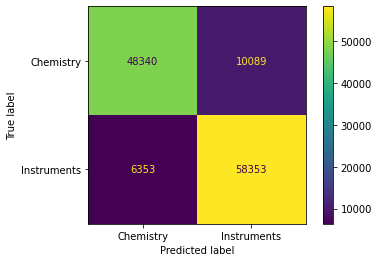

In [43]:
# Initiate the model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Make predictions for test data
y_hat_train = xgb.predict(X_train)

# Make predictions for test data
y_hat_test = xgb.predict(X_test)

# Evaluate model
model_scores(xgb, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

In [ ]:
# from gensim.models import Word2Vec
# from nltk import word_tokenize

In [ ]:
# import nltk
# nltk.download('punkt')

In [ ]:
# data = df['text'].map(word_tokenize)
# data[:5]

In [ ]:
# model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)
# model.train(data, total_examples=model.corpus_count, epochs=10)
# wv = model.wv